# テーマ：CIFAR-10データセットを畳み込みニューラルネットワーク（CNN）で学習する

## 制約
* 全体の実行時間は60分以内

## 今回参考にしたもの
* [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
* [practice on CIFAR10 with Keras](https://github.com/jerett/Keras-CIFAR10)

## 0. Install TensorFlow 2.0

In [0]:
!pip install tensorflow-gpu==2.0.0-alpha0

## 1. Prepare dataset

In [0]:
import tensorflow_datasets as tfds
import tensorflow as tf

# print(tfds.list_builders())
dataset, info = tfds.load('cifar10', as_supervised = True, with_info = True, batch_size = -1)
dataset_test, dataset_train = dataset['test'], dataset['train']
print(info)

tfds.core.DatasetInfo(
    name='cifar10',
    version=1.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    urls=['https://www.cs.toronto.edu/~kriz/cifar.html'],
    features=FeaturesDict({
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10)
    },
    total_num_examples=60000,
    splits={
        'test': <tfds.core.SplitInfo num_examples=10000>,
        'train': <tfds.core.SplitInfo num_examples=50000>
    },
    supervised_keys=('image', 'label'),
    citation='"""
        @TECHREPORT{Krizhevsky09learningmultiple,
            author = {Alex Krizhevsky},
            title = {Learning multiple layers of features from tiny images},
            institution = {},
            year = {2009}
        }
        
    """',
    redistribution_info=,
)



In [0]:
import numpy as np

train_x = dataset_train[0] / 255
train_y = dataset_train[1]
test_x = dataset_test[0] / 255
test_y = dataset_test[1]

# Per-pixel Mean Subtraction
# mean_image = np.mean(train_x, axis=0)
# train_x -= mean_image
# test_x -= mean_image            

## 2. Data Augmentation

In [0]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class CustomImageDataGenerator(ImageDataGenerator):
    def __init__(self, cutout_mask_size = 0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cutout_mask_size = cutout_mask_size
        
    def cutout(self, x, y):
        return np.array(list(map(self._cutout, x))), y
    
    def _cutout(self, image_origin):
        # 最後に使うfill()は元の画像を書き換えるので、コピーしておく
        image = np.copy(image_origin)
        mask_value = image.mean()

        h, w, _ = image.shape
        # マスクをかける場所のtop, leftをランダムに決める
        # はみ出すことを許すので、0以上ではなく負の値もとる(最大mask_size // 2はみ出す)
        top = np.random.randint(0 - self.cutout_mask_size // 2, h - self.cutout_mask_size)
        left = np.random.randint(0 - self.cutout_mask_size // 2, w - self.cutout_mask_size)
        bottom = top + self.cutout_mask_size
        right = left + self.cutout_mask_size

        # はみ出した場合の処理
        if top < 0:
            top = 0
        if left < 0:
            left = 0

        # マスク部分の画素値を平均値で埋める
        image[top:bottom, left:right, :].fill(mask_value)
        return image
    
    def flow(self, *args, **kwargs):
        batches = super().flow(*args, **kwargs)
        
        # 拡張処理
        while True:
            batch_x, batch_y = next(batches)
            
            if self.cutout_mask_size > 0:
                result = self.cutout(batch_x, batch_y)
                batch_x, batch_y = result                        
                
            yield (batch_x, batch_y)     

datagen_parameters = {"horizontal_flip": True, "width_shift_range": 0.1, "height_shift_range": 0.1, "cutout_mask_size": 16}
datagen = CustomImageDataGenerator(**datagen_parameters)
datagen_for_test = ImageDataGenerator()
# ZCA whiteningなどを行う場合が以下の実行が必要
# datagen.fit(train_x)
# datagen_for_test.fit(test_x)

## 3. Define model

In [0]:
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, MaxPool2D, GlobalAveragePooling2D, Add, Input, Flatten
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2

n = 9 # 56 layers
channels = [16, 32, 64]

inputs = Input(shape=(32, 32, 3))
x = Conv2D(channels[0], kernel_size=(3, 3), padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = Activation(tf.nn.relu)(x)

for c in channels:
    for i in range(n):
        subsampling = i == 0 and c > 16
        strides = (2, 2) if subsampling else (1, 1)
        y = Conv2D(c, kernel_size=(3, 3), padding="same", strides=strides, kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(x)
        y = BatchNormalization()(y)
        y = Activation(tf.nn.relu)(y)
        y = Conv2D(c, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(y)
        y = BatchNormalization()(y)        
        if subsampling:
            x = Conv2D(c, kernel_size=(1, 1), strides=(2, 2), padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(x)
        x = Add()([x, y])
        x = Activation(tf.nn.relu)(x)

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
outputs = Dense(10, activation=tf.nn.softmax, kernel_initializer="he_normal")(x)

model = Model(inputs=inputs, outputs=outputs)
model.type = "resnet" + str(6 * n + 2)

In [0]:
from io import StringIO
import re

with StringIO() as buf:
    model.summary(print_fn=lambda x: buf.write(x + "\n"))
    summary = buf.getvalue()
print(summary)
re1 = re.match(r"(.|\s)*Total params: ", summary)
re2 = re.match(r"(.|\s)*Total params: [\d|,]+", summary)
total_params = summary[re1.end():re2.end()]

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v2_55 (Batc (None, 32, 32, 16)   64          conv2d_57[0][0]                  
__________________________________________________________________________________________________
activation_55 (Activation)      (None, 32, 32, 16)   0           batch_normalization_v2_55[0][0]  
____________________________________________________________________________________________

## 4. Prepare training

In [0]:
from tensorflow.keras.optimizers import Adam, SGD

# lr = 0.001
# optimizer = Adam(learning_rate=lr)
lr = 0.1
optimizer = SGD(learning_rate=lr, momentum=0.9)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [0]:
!pip install hyperdash
from hyperdash import monitor_cell
!hyperdash signup --github

In [0]:
from hyperdash import Experiment
exp = Experiment("ResNet-for-CIFAR-10-with-Keras")

In [0]:
from tensorflow.keras.callbacks import Callback
import time

class Hyperdash(Callback):
    def __init__(self, entries, exp):
        super(Hyperdash, self).__init__()
        self.entries = entries
        self.exp = exp

    def on_epoch_end(self, epoch, logs=None):
        for entry in self.entries:
            log = logs.get(entry)            
            if log is not None:
                self.exp.metric(entry, log)

class LearningController(Callback):
    def __init__(self, num_epoch=0, learn_minute=0):
        self.num_epoch = num_epoch
        self.learn_second = learn_minute * 60
        if self.learn_second > 0:
            print("Leraning rate is controled by time.")
        elif self.num_epoch > 0:
            print("Leraning rate is controled by epoch.")
        
    def on_train_begin(self, logs=None):
        if self.learn_second > 0:
            self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        if self.learn_second > 0:
            current_time = time.time()
            if current_time - self.start_time > self.learn_second:
                self.model.stop_training = True
                print("Time is up.")
                return

            if current_time - self.start_time > self.learn_second / 2:
                self.model.optimizer.lr = lr * 0.1            
            if current_time - self.start_time > self.learn_second * 3 / 4:
                self.model.optimizer.lr = lr * 0.01
                
        elif self.num_epoch > 0:
            if epoch > self.num_epoch / 2:
                self.model.optimizer.lr = lr * 0.1            
            if epoch > self.num_epoch * 3 / 4:
                self.model.optimizer.lr = lr * 0.01
                    
        print('lr:%.2e' % self.model.optimizer.lr.value())

In [0]:
num_epoch = 182
learn_minute = 120

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint

hyperdash = Hyperdash(["val_loss", "loss", "val_accuracy", "accuracy"], exp)
checkpoint = ModelCheckpoint(filepath = "ResNet-for-CIFAR-10-with-Keras.h5", monitor="val_loss", verbose=1, save_best_only=True)
learning_controller = LearningController(num_epoch)
callbacks = [hyperdash, checkpoint, learning_controller]

## 5. Train

In [0]:
batch_size = 128
number_train = info.splits["train"].num_examples
number_test = info.splits["test"].num_examples

In [0]:
import json

exp.param("Model type", model.type)
exp.param("Total params", total_params)
exp.param("Optimizer", optimizer)
exp.param("Leraning rate", lr)
exp.param("Datagen", json.dumps(datagen_parameters))
exp.param("Batch size", batch_size)
exp.param("Number of epoch", num_epoch)
exp.param("Learn minute", learn_minute)

120

In [0]:
history = model.fit(datagen.flow(train_x, train_y, batch_size=batch_size), 
                    epochs=num_epoch, 
                    steps_per_epoch=number_train//batch_size, 
                    validation_data=datagen_for_test.flow(test_x, test_y, batch_size=batch_size), 
                    validation_steps=number_test//batch_size,
                    verbose=0,                    
                    callbacks=callbacks)
exp.end()

## 6. Show transition of accuracy

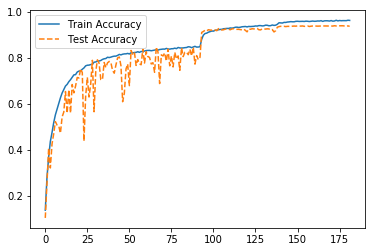

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], label = 'Train Accuracy')
plt.plot(history.history["val_accuracy"], linestyle = 'dashed', label = 'Test Accuracy')
plt.legend()
plt.show()

In [0]:
model.evaluate(test_x, test_y)

10000/10000 [==============================] - 3s 323us/sample - loss: 0.3844 - accuracy: 0.9358


[0.3843775578975677, 0.9358]